In [1]:
import numpy as np
import os
import gdal, osr
import matplotlib.pyplot as plt
import sys
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
%matplotlib inline 

In [2]:
from skimage.morphology import watershed
from skimage.feature import peak_local_max
from skimage.measure import regionprops
from sklearn.ensemble import RandomForestRegressor

In [3]:
# -*- coding: utf-8 -*-
"""
Created on Wed Jun 20 10:34:49 2018

@author: bhass

neon_aop_hyperspectral contains the following functions for use in the 2018
Remote Sensing Data Institute 

list_dataset (called with h5py.File.visititems):
    lists the name and location of each dataset stored in an hdf5 file 

ls_dataset (called with h5py.File.visititems):
    lists name, shape, and type of each dataset stored in an hdf5 file

aop_h5refl2array:
    reads in NEON AOP reflectance hdf5 file, convert to a cleaned reflectance 
    array and return associated metadata (spatial information and band center 
    wavelengths)

plot_aop_refl:
    reads in and plot a single band or 3 stacked bands of a reflectance array
    
stack_rgb:
    extracts and stacks three bands of a reflectance array
    
plot_aop_rgb:
    reads in and plots 3 bands of a reflectance array as an RGB image
    
"""
import pandas as pd
import copy
import warnings
warnings.filterwarnings('ignore') #don't display warnings

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import h5py
from skimage import exposure

def list_dataset(name,node):
    
    """list_dataset lists the name and location of each dataset stored in an hdf5 file.
    --------
    See Also:
    --------
    ls_dataset: 
        Lists name, shape, and type of each dataset stored in an hdf5 file.
    --------
    Usage:
    --------
    f = h5py.File('NEON_D02_SERC_DP3_368000_4306000_reflectance.h5','r') 
    f.visititems(list_dataset)"""
    
    if isinstance(node, h5py.Dataset):
        print(name)

def ls_dataset(name,node):
    
    """ls_dataset lists the name, shape, and datatype of each dataset stored in 
    an hdf5 file.
    --------
    See Also
    --------
    list_dataset: 
        Lists name and location of each dataset stored in an hdf5 file
    Example:
    --------
    f = h5py.File('NEON_D02_SERC_DP3_368000_4306000_reflectance.h5','r') 
    f.visititems(ls_dataset)"""
    
    if isinstance(node, h5py.Dataset):
        print(node)

def aop_h5refl2array(refl_filename):
    """read in NEON AOP reflectance hdf5 file, convert to a cleaned reflectance 
    array and return associated metadata (spatial information and band center 
    wavelengths)
           
    Parameters
    ----------
        refl_filename : string
            reflectance hdf5 file name, including full or relative path

    Returns 
    --------
    reflArray : ndarray
        array of reflectance values
    metadata: dictionary 
        associated metadata containing
            bad_band_window1 (tuple)
            bad_band_window2 (tuple)
            bands: # of bands (float)
            data ignore value: value corresponding to no data (float)
            epsg: coordinate system code (float)
            map info: coordinate system, datum & ellipsoid, pixel dimensions, and origin coordinates (string)
            reflectance scale factor: factor by which reflectance is scaled (float)
            wavelength: center wavelengths of bands (float)
            wavelength unit: 'm' (string)
    --------
    NOTE: This function applies to the NEON hdf5 format implemented in 2016, and should be used for
    data acquired 2016 and after. Data in earlier NEON hdf5 format (collected prior to 2016) is 
    expected to be re-processed after the 2018 flight season. 
    --------
    Example Execution:
    --------
    sercRefl, sercRefl_metadata = h5refl2array('NEON_D02_SERC_DP3_368000_4306000_reflectance.h5') """
    
    
    #Read in reflectance hdf5 file 
    hdf5_file = h5py.File(refl_filename,'r')
    
    #Get the site name
    file_attrs_string = str(list(hdf5_file.items()))
    file_attrs_string_split = file_attrs_string.split("'")
    sitename = file_attrs_string_split[1]
    
    #Extract the reflectance & wavelength datasets
    refl = hdf5_file[sitename]['Reflectance']
    
    
    reflData = refl['Reflectance_Data']
    reflRaw = refl['Reflectance_Data'].value
    
    #Create dictionary containing relevant metadata information
    metadata = {}
    metadata['map info'] = refl['Metadata']['Coordinate_System']['Map_Info'].value
    metadata['wavelength'] = refl['Metadata']['Spectral_Data']['Wavelength'].value

    #Extract no data value & scale factor
    metadata['data ignore value'] = float(reflData.attrs['Data_Ignore_Value'])
    metadata['reflectance scale factor'] = float(reflData.attrs['Scale_Factor'])
    #metadata['interleave'] = reflData.attrs['Interleave']
    
    #Apply no data value
    reflClean = reflRaw.astype(float)
    arr_size = reflClean.shape
    if metadata['data ignore value'] in reflRaw:
        print('% No Data: ',np.round(np.count_nonzero(reflClean==metadata['data ignore value'])*100/(arr_size[0]*arr_size[1]*arr_size[2]),1))
        nodata_ind = np.where(reflClean==metadata['data ignore value'])
        reflClean[nodata_ind]=np.nan 
    
    #Apply scale factor
    reflArray = reflClean/metadata['reflectance scale factor']
    
    #Extract spatial extent from attributes
    metadata['spatial extent'] = reflData.attrs['Spatial_Extent_meters']
    
    #Extract bad band windows
    metadata['bad band window1'] = (refl.attrs['Band_Window_1_Nanometers'])
    metadata['bad band window2'] = (refl.attrs['Band_Window_2_Nanometers'])
    
    #Extract projection information
    #metadata['projection'] = refl['Metadata']['Coordinate_System']['Proj4'].value
    metadata['epsg'] = int(refl['Metadata']['Coordinate_System']['EPSG Code'].value)
    
    #Extract map information: spatial extent & resolution (pixel size)
    metadata['map info'] = refl['Metadata']['Coordinate_System']['Map_Info'].value
    
    hdf5_file.close        
    
    return reflArray, metadata

def plot_aop_refl(band_array,refl_extent,colorlimit=(0,1),ax=plt.gca(),title='',cbar ='on',cmap_title='',colormap='Greys'):
    
    ''' read in and plot a single band or 3 stacked bands of a reflectance array
    --------
    Parameters
    --------
        band_array: ndarray
            Array of reflectance values, created from aop_h5refl2array
            If 'band_array' is a 2-D array, plots intensity of values
            If 'band_array' is a 3-D array (3 bands), plots RGB image, set cbar to 'off' and don't need to specify colormap 
        refl_extent: tuple
            Extent of reflectance data to be plotted (xMin, xMax, yMin, yMax) 
            Stored in metadata['spatial extent'] from aop_h5refl2array function
        colorlimit: tuple, optional
            Range of values to plot (min,max). 
            Look at the histogram of reflectance values before plotting to determine colorlimit.
        ax: axis handle, optional
            Axis to plot on; specify if making figure with subplots. Default is current axis, plt.gca()
        title: string, optional
            plot title 
        cbar: string, optional
            Use cbar = 'on' (default), shows colorbar; use if plotting 1-band array
            If cbar = 'off' (or not 'on'), does no
        cmap_title: string, optional
            colorbar title (eg. 'reflectance', etc.)
        colormap: string, optional
            Matplotlib colormap to plot 
            see https://matplotlib.org/examples/color/colormaps_reference.html

    Returns 
    --------
        plots flightline array of single band of reflectance data
    --------

    Examples:
    --------
    >>> plot_aop_refl(sercb56,
              sercMetadata['spatial extent'],
              colorlimit=(0,0.3),
              title='SERC Band 56 Reflectance',
              cmap_title='Reflectance',
              colormap='Greys_r') '''
    
    plot = plt.imshow(band_array,extent=refl_extent,clim=colorlimit); 
    if cbar == 'on':
        cbar = plt.colorbar(plot,aspect=40); plt.set_cmap(colormap); 
        cbar.set_label(cmap_title,rotation=90,labelpad=20)
    plt.title(title); ax = plt.gca(); 
    ax.ticklabel_format(useOffset=False, style='plain'); #do not use scientific notation for ticklabels
    rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90); #rotate x tick labels 90 degrees
    
def stack_rgb(reflArray,bands):
    
    ''' extract and stack three bands of a reflectance array 
    --------
    Parameters
    --------
        reflArray: ndarray (m x n x #bands)
            Array of reflectance values, created from aop_h5refl2array
        bands: tuple
            Indices of bands to extract (R,G,B)

    Returns 
    --------
        stackedRGB: ndarray (m x n x 3)
            array containing 3 bands specified 
    --------

    Examples:
    --------
    >>> stack_rgb(sercRefl,(58,34,19)) '''
    
    red = reflArray[:,:,bands[0]-1]
    green = reflArray[:,:,bands[1]-1]
    blue = reflArray[:,:,bands[2]-1]
    
    stackedRGB = np.stack((red,green,blue),axis=2)
    
    return stackedRGB

def plot_aop_rgb(rgbArray,ext,ls_pct=5,plot_title=''):
    
    ''' read in and plot 3 bands of a reflectance array as an RGB image
    --------
    Parameters
    --------
        rgbArray: ndarray (m x n x 3)
            3-band array of reflectance values, created from stack_rgb
        ext: tuple
            Extent of reflectance data to be plotted (xMin, xMax, yMin, yMax) 
            Stored in metadata['spatial extent'] from aop_h5refl2array function
        ls_pct: integer or float, optional
            linear stretch percent
        plot_title: string, optional
            image title

    Returns 
    --------
        plots RGB image of 3 bands of reflectance data
    --------

    Examples:
    --------
    >>> plot_aop_rgb(SERCrgb,
                     sercMetadata['spatial extent'],
                     plot_title = 'SERC RGB')'''
    
    pLow, pHigh = np.percentile(rgbArray[~np.isnan(rgbArray)], (ls_pct,100-ls_pct))
    img_rescale = exposure.rescale_intensity(rgbArray, in_range=(pLow,pHigh))
    plt.imshow(img_rescale,extent=ext)
    plt.title(plot_title + '\n Linear ' + str(ls_pct) + '% Contrast Stretch'); 
    ax = plt.gca(); ax.ticklabel_format(useOffset=False, style='plain') 
    rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90) 
    
    
def read_neon_reflh5(refl_filename):
    """read in a NEON AOP reflectance hdf5 file and returns 
    reflectance array, and metadata dictionary containing metadata 
    (similar to envi header format)
    --------
    Parameters
        refl_filename -- full or relative path and name of reflectance hdf5 file
    --------
    Returns 
    --------
    reflArray:
        array of reflectance values
    metadata:
        dictionary containing the following metadata (all strings):
            bad_band_window1: min and max wavelenths of first water vapor window (tuple)
            bad_band_window2: min and max wavelenths of second water vapor window (tuple)
            bands: # of bands (float)
            coordinate system string: coordinate system information (string)
            data ignore value: value corresponding to no data (float)
            interleave: 'BSQ' (string)
            reflectance scale factor: factor by which reflectance is scaled (float)
            wavelength: wavelength values (float)
            wavelength unit: 'm' (string)
            spatial extent: extent of tile [xMin, xMax, yMin, yMax], UTM meters
    --------
    Example Execution:
    --------
    sercRefl, sercMetadata = h5refl2array('NEON_D02_SERC_DP1_20160807_160559_reflectance.h5') """

    #Read in reflectance hdf5 file 
    hdf5_file = h5py.File(refl_filename,'r')

    #Get the site name
    file_attrs_string = str(list(hdf5_file.items()))
    file_attrs_string_split = file_attrs_string.split("'")
    sitename = file_attrs_string_split[1]

    #Extract the reflectance & wavelength datasets
    refl = hdf5_file[sitename]['Reflectance']
    reflData = refl['Reflectance_Data']
    reflArray = refl['Reflectance_Data'].value

    #Create dictionary containing relevant metadata information
    metadata = {}
    metadata['map info'] = refl['Metadata']['Coordinate_System']['Map_Info'].value
    metadata['wavelength'] = refl['Metadata']['Spectral_Data']['Wavelength'].value

    #Extract no data value & set no data value to NaN
    metadata['data ignore value'] = float(reflData.attrs['Data_Ignore_Value'])
    metadata['reflectance scale factor'] = float(reflData.attrs['Scale_Factor'])
    metadata['interleave'] = reflData.attrs['Interleave']

    #Extract spatial extent from attributes
    metadata['spatial extent'] = reflData.attrs['Spatial_Extent_meters']

    #Extract bad band windows
    metadata['bad_band_window1'] = (refl.attrs['Band_Window_1_Nanometers'])
    metadata['bad_band_window2'] = (refl.attrs['Band_Window_2_Nanometers'])

    #Extract projection information
    metadata['projection'] = refl['Metadata']['Coordinate_System']['Proj4'].value
    metadata['epsg'] = int(refl['Metadata']['Coordinate_System']['EPSG Code'].value)

    #Extract map information: spatial extent & resolution (pixel size)
    mapInfo = refl['Metadata']['Coordinate_System']['Map_Info'].value

    hdf5_file.close        

    return reflArray, metadata


def clean_neon_refl_data(data,metadata):
    """Clean h5 reflectance data and metadata
    1. set data ignore value (-9999) to NaN
    2. apply reflectance scale factor (10000)
    3. remove bad bands (water vapor band windows + last 10 bands): 
        Band_Window_1_Nanometers = 1340,1445
        Band_Window_2_Nanometers = 1790,1955
    """

    # use copy so original data and metadata doesn't change
    data_clean = data.copy().astype(float)
    metadata_clean = metadata.copy()

    #set data ignore value (-9999) to NaN:
    if metadata['data ignore value'] in data:
        nodata_ind = np.where(data_clean==metadata['data ignore value'])
        data_clean[nodata_ind]=np.nan 

    #apply reflectance scale factor (divide by 10000)
    data_clean = data_clean/metadata['reflectance scale factor']

    #remove bad bands 
    #1. define indices corresponding to min/max center wavelength for each bad band window:
    bb1_ind0 = np.max(np.where((np.asarray(metadata['wavelength'])<float(metadata['bad_band_window1'][0]))))
    bb1_ind1 = np.min(np.where((np.asarray(metadata['wavelength'])>float(metadata['bad_band_window1'][1]))))

    bb2_ind0 = np.max(np.where((np.asarray(metadata['wavelength'])<float(metadata['bad_band_window2'][0]))))
    bb2_ind1 = np.min(np.where((np.asarray(metadata['wavelength'])>float(metadata['bad_band_window2'][1]))))

    bb3_ind0 = len(metadata['wavelength'])-10

    #define valid band ranges from indices:
    vb1 = list(range(0,bb1_ind0)); 
    vb2 = list(range(bb1_ind1,bb2_ind0))
    vb3 = list(range(bb2_ind1,bb3_ind0))

    valid_band_range = [i for j in (range(0,bb1_ind0),
                                    range(bb1_ind1,bb2_ind0),
                                    range(bb2_ind1,bb3_ind0)) for i in j]

    data_clean = data_clean[:,:,vb1+vb2+vb3]

    metadata_clean['wavelength'] = [metadata['wavelength'][i] for i in valid_band_range]

    return data_clean, metadata_clean


# Define plot band array function

def plot_band_array(band_array,image_extent,title,cmap_title,colormap,colormap_limits):
    plt.imshow(band_array,extent=image_extent)
    cbar = plt.colorbar(); plt.set_cmap(colormap); plt.clim(colormap_limits)
    cbar.set_label(cmap_title,rotation=270,labelpad=20)
    plt.title(title); ax = plt.gca()
    ax.ticklabel_format(useOffset=False, style='plain') 
    rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90)

# Define a function that will allow us to output GeoTIFF files.
def array2raster(newRasterfn,rasterOrigin,pixelWidth,pixelHeight,array,epsg):

    cols = array.shape[1]
    rows = array.shape[0]
    originX = rasterOrigin[0]
    originY = rasterOrigin[1]

    driver = gdal.GetDriverByName('GTiff')
    outRaster = driver.Create(newRasterfn, cols, rows, 1, gdal.GDT_Float32)
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
    outband = outRaster.GetRasterBand(1)
    outband.WriteArray(array)
    outRasterSRS = osr.SpatialReference()
    outRasterSRS.ImportFromEPSG(epsg)
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()
    

# Define a functoin that transform raster to array
def raster2array(geotif_file):
    metadata = {}
    dataset = gdal.Open(geotif_file)
    metadata['array_rows'] = dataset.RasterYSize
    metadata['array_cols'] = dataset.RasterXSize
    metadata['bands'] = dataset.RasterCount
    metadata['driver'] = dataset.GetDriver().LongName
    metadata['projection'] = dataset.GetProjection()
    metadata['geotransform'] = dataset.GetGeoTransform()

    mapinfo = dataset.GetGeoTransform()
    metadata['pixelWidth'] = mapinfo[1]
    metadata['pixelHeight'] = mapinfo[5]

    metadata['ext_dict'] = {}
    metadata['ext_dict']['xMin'] = mapinfo[0]
    metadata['ext_dict']['xMax'] = mapinfo[0] + dataset.RasterXSize/mapinfo[1]
    metadata['ext_dict']['yMin'] = mapinfo[3] + dataset.RasterYSize/mapinfo[5]
    metadata['ext_dict']['yMax'] = mapinfo[3]

    metadata['extent'] = (metadata['ext_dict']['xMin'],metadata['ext_dict']['xMax'],
                          metadata['ext_dict']['yMin'],metadata['ext_dict']['yMax'])

    if metadata['bands'] == 1:
        raster = dataset.GetRasterBand(1)
        metadata['noDataValue'] = raster.GetNoDataValue()
        metadata['scaleFactor'] = raster.GetScale()

        # band statistics
        metadata['bandstats'] = {} #make a nested dictionary to store band stats in same 
        stats = raster.GetStatistics(True,True)
        metadata['bandstats']['min'] = round(stats[0],2)
        metadata['bandstats']['max'] = round(stats[1],2)
        metadata['bandstats']['mean'] = round(stats[2],2)
        metadata['bandstats']['stdev'] = round(stats[3],2)

        array = dataset.GetRasterBand(1).ReadAsArray(0,0,metadata['array_cols'],metadata['array_rows']).astype(np.float)
        array[array==int(metadata['noDataValue'])]=np.nan
        array = array/metadata['scaleFactor']
        return array, metadata

    elif metadata['bands'] > 1:
        print('More than one band ... need to modify function for case of multiple bands')
        

import cvxopt
import sklearn
from spectral import *
import spectral.io.envi as envi
import numpy as np
import matplotlib.pyplot as plt
import gdal
import osr
%matplotlib inline

#for clean output, to not print warnings, don't use when developing script
import warnings
warnings.filterwarnings('ignore')


In [4]:
def plot_band_array(band_array,image_extent,title,cmap_title,colormap,colormap_limits):
    plt.imshow(band_array,extent=image_extent)
    cbar = plt.colorbar(); plt.set_cmap(colormap); plt.clim(colormap_limits)
    cbar.set_label(cmap_title,rotation=270,labelpad=20)
    plt.title(title); ax = plt.gca()
    ax.ticklabel_format(useOffset=False, style='plain') 
    rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90)

In [5]:
def array2raster(newRasterfn,rasterOrigin,pixelWidth,pixelHeight,array,epsg):

    cols = array.shape[1]
    rows = array.shape[0]
    originX = rasterOrigin[0]
    originY = rasterOrigin[1]

    driver = gdal.GetDriverByName('GTiff')
    outRaster = driver.Create(newRasterfn, cols, rows, 1, gdal.GDT_Float32)
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
    outband = outRaster.GetRasterBand(1)
    outband.WriteArray(array)
    outRasterSRS = osr.SpatialReference()
    outRasterSRS.ImportFromEPSG(epsg)
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()


In [6]:
chm_file = '../../Data/capstone/2017/NEON_D17_SJER_DP3_258000_4108000_CHM.tif'

In [7]:
#Get info from chm file for outputting results
just_chm_file = os.path.basename(chm_file)
just_chm_file_split = just_chm_file.split(sep="_")


In [8]:
def raster2array(geotif_file):
    metadata = {}
    dataset = gdal.Open(geotif_file)
    metadata['array_rows'] = dataset.RasterYSize
    metadata['array_cols'] = dataset.RasterXSize
    metadata['bands'] = dataset.RasterCount
    metadata['driver'] = dataset.GetDriver().LongName
    metadata['projection'] = dataset.GetProjection()
    metadata['geotransform'] = dataset.GetGeoTransform()

    mapinfo = dataset.GetGeoTransform()
    metadata['pixelWidth'] = mapinfo[1]
    metadata['pixelHeight'] = mapinfo[5]

    metadata['ext_dict'] = {}
    metadata['ext_dict']['xMin'] = mapinfo[0]
    metadata['ext_dict']['xMax'] = mapinfo[0] + dataset.RasterXSize/mapinfo[1]
    metadata['ext_dict']['yMin'] = mapinfo[3] + dataset.RasterYSize/mapinfo[5]
    metadata['ext_dict']['yMax'] = mapinfo[3]

    metadata['extent'] = (metadata['ext_dict']['xMin'],metadata['ext_dict']['xMax'],
                          metadata['ext_dict']['yMin'],metadata['ext_dict']['yMax'])

    if metadata['bands'] == 1:
        raster = dataset.GetRasterBand(1)
        metadata['noDataValue'] = raster.GetNoDataValue()
        metadata['scaleFactor'] = raster.GetScale()

        # band statistics
        metadata['bandstats'] = {} #make a nested dictionary to store band stats in same 
        stats = raster.GetStatistics(True,True)
        metadata['bandstats']['min'] = round(stats[0],2)
        metadata['bandstats']['max'] = round(stats[1],2)
        metadata['bandstats']['mean'] = round(stats[2],2)
        metadata['bandstats']['stdev'] = round(stats[3],2)

        array = dataset.GetRasterBand(1).ReadAsArray(0,0,metadata['array_cols'],metadata['array_rows']).astype(np.float)
        array[array==int(metadata['noDataValue'])]=np.nan
        array = array/metadata['scaleFactor']
        return array, metadata

    elif metadata['bands'] > 1:
        print('More than one band ... need to modify function for case of multiple bands')

In [9]:
#Open the CHM file with GDAL
chm_dataset = gdal.Open(chm_file)

#Get the raster band object
chm_raster = chm_dataset.GetRasterBand(1)


In [10]:
#Get the NO DATA value
noDataVal_chm = chm_raster.GetNoDataValue()

In [11]:
#Get required metadata from CHM file
cols_chm = chm_dataset.RasterXSize
rows_chm = chm_dataset.RasterYSize
bands_chm = chm_dataset.RasterCount
mapinfo_chm =chm_dataset.GetGeoTransform()
xMin = mapinfo_chm[0]
yMax = mapinfo_chm[3]
xMax = xMin + chm_dataset.RasterXSize/mapinfo_chm[1]
yMin = yMax + chm_dataset.RasterYSize/mapinfo_chm[5]
image_extent = (xMin,xMax,yMin,yMax)

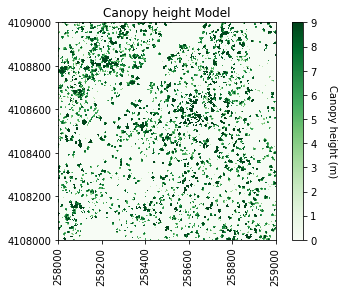

In [12]:
#Plot the original CHM
plt.figure(1)
chm_array = chm_raster.ReadAsArray(0,0,cols_chm,rows_chm).astype(np.float)

#PLot the CHM figure
plot_band_array(chm_array,image_extent,'Canopy height Model','Canopy height (m)','Greens',[0, 9])
plt.savefig(just_chm_file_split[0]+'_'+just_chm_file_split[1]+'_'+just_chm_file_split[2]+'_'+just_chm_file_split[3]+'_'+just_chm_file_split[4]+'_'+just_chm_file_split[5]+'_'+'CHM.png',dpi=300,orientation='landscape',bbox_inches='tight',pad_inches=0.1)


In [13]:
#Smooth the CHM using a gaussian filter to remove spurious points
chm_array_smooth = ndi.gaussian_filter(chm_array,2,mode='constant',cval=0,truncate=2.0)
chm_array_smooth[chm_array==0] = 0 

In [14]:
#Save the smoothed CHM, #32611 is the format of the data file
array2raster('../output/2017chm_filter.tif',(xMin,yMax),1,-1,np.array(chm_array_smooth/10000,dtype=float),32611)

In [15]:
 #Calculate local maximum points in the smoothed CHM
local_maxi = peak_local_max(chm_array_smooth,indices=False, footprint=np.ones((5, 5)))

TypeError: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

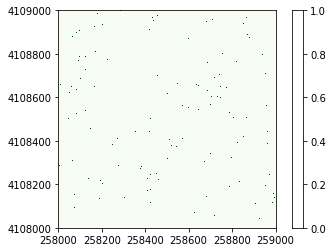

In [17]:
#Plot the local maximums
plt.figure(2)
plot_band_array(local_maxi,image_extent,'Maximum','Maxi','Greys',[0, 1])
plt.savefig(just_chm_file_split[0]+'_'+just_chm_file_split[1]+'_'+just_chm_file_split[2]+'_'+just_chm_file_split[3]+'_'+just_chm_file_split[4]+'_'+just_chm_file_split[5]+'_'+'Maximums.png',dpi=300,orientation='landscape',bbox_inches='tight',pad_inches=0.1)

In [18]:
#Identify all the maximum points
markers = ndi.label(local_maxi)[0]

In [19]:
#Create a CHM mask so the segmentation will only occur on the trees
chm2017_mask = chm_array_smooth.copy()
chm2017_mask[chm_array_smooth != 0] = 1


In [20]:
#Perfrom watershed segmentation        
labels = watershed(chm_array_smooth, markers, mask=chm2017_mask)

In [21]:
#Get the properties of each segment
tree_properties = regionprops(labels,chm_array, ['Area','BoundingBox','Centroid','Orientation','MajorAxisLength','MinorAxisLength','MaxIntensity','MinIntensity'])

### After mask tree, we do k-mean unsupervised classification on trees only


In [22]:
sercRefl, sercRefl_md = read_neon_reflh5('../../Data/capstone/2018/NEON_D17_SJER_DP3_258000_4108000_reflectance.h5')

In [23]:
sercRefl_clean, sercRefl_md_clean = clean_neon_refl_data(sercRefl, sercRefl_md)

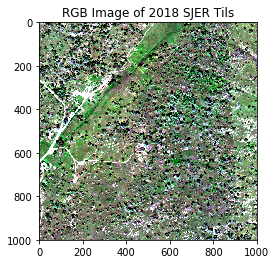

In [24]:
view = imshow(sercRefl_clean,
              bands=[58,34,19],
              stretch=0.05,
              title='RGB Image of 2018 SJER Tils'
             )

    ## apply tree mask on cleaned AOP hyperspectral data before k-mean
    ## run classification on trees first
    

In [25]:
sercRefl_clean_aftermask = sercRefl_clean.copy()

for item in range(0,359):
    sercRefl_clean_aftermask[:,:,item] = sercRefl_clean_aftermask[:,:,item]*chm2017_mask




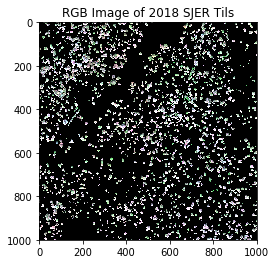

In [26]:
view = imshow(sercRefl_clean_aftermask,
              bands=[58,34,19],
              stretch=0.05,
              title='RGB Image of 2018 SJER Tils'
             )


In [27]:
(m,c) = kmeans(sercRefl_clean_aftermask,5,20)


Initializing clusters along diagonal of N-dimensional bounding box.
Iteration 1...  0.Iteration 1...182527 pixels reassigned.
Iteration 2...  0.Iteration 2...26395 pixels reassigned.
Iteration 3...  0.Iteration 3...17780 pixels reassigned.
Iteration 4...  0.Iteration 4...15634 pixels reassigned.
Iteration 5...  0.Iteration 5...15898 pixels reassigned.
Iteration 6...  0.Iteration 6...13301 pixels reassigned.
Iteration 7...  0.Iteration 7...9457 pixels reassigned.
Iteration 8...  0.Iteration 8...6529 pixels reassigned.
Iteration 9...  0.Iteration 9...5546 pixels reassigned.
Iteration 10...  0.0Iteration 10...6885 pixels reassigned.
Iteration 11...  0.0Iteration 11...9510 pixels reassigned.
Iteration 12...  0.0Iteration 12...11110 pixels reassigned.
Iteration 13...  0.0Iteration 13...10379 pixels reassigned.
Iteration 14...  0.0Iteration 14...9170 pixels reassigned.
Iteration 15...  0.0Iteration 15...8000 pixels reassigned.
Iteration 16...  0.0Iteration 16...7340 pixels reassigned.
Iterat

Text(0,0.5,'Reflectance')

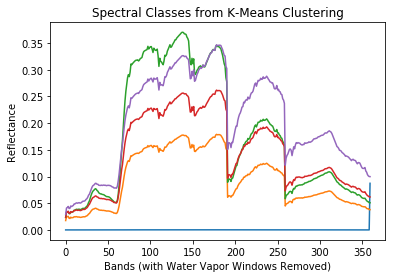

In [28]:
%matplotlib inline
import pylab
pylab.figure()
pylab.hold(1)
for i in range(c.shape[0]):
    pylab.plot(c[i])
pylab.show
pylab.title('Spectral Classes from K-Means Clustering')
pylab.xlabel('Bands (with Water Vapor Windows Removed)')
pylab.ylabel('Reflectance')

<bound method ImageView.show_data of ImageView object:
  Display bands       :  (58, 34, 19)
  Interpolation       :  <default>
  RGB data limits     :
    R: [129.0, 1820.0]
    G: [175.0, 1553.0]
    B: [106.0, 1193.0]
>

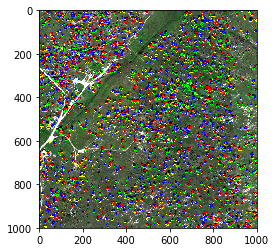

In [29]:
#%matplotlib notebook
# subplot in matplot can make side-by-sde plot
view = imshow(sercRefl, bands=(58,34,19),stretch=0.01, classes=m)
view.set_display_mode('overlay')
view.class_alpha = 1 #set transparency
view.show_data

In [30]:
# save classification results
array2raster('../output/fig/SJER_2017_unpupervised_classification_5groups_treeonly.tif',
             (sercRefl_md['spatial extent'][0],sercRefl_md['spatial extent'][3]),
             1,-1,
             np.array(m,dtype=float),
             32611)

## run classification on no-tree pixels


In [31]:
np.max(chm2017_mask)

1.0

In [32]:
np.min(chm2017_mask)

0.0

In [33]:
#Create a CHM mask so the segmentation will only occur on the no-trees
chm2017_mask_notree = chm_array_smooth.copy()
chm2017_mask_notree[chm_array_smooth == 0] = 1
chm2017_mask_notree[chm_array_smooth > 0] = 0
#np.count_nonzero(chm2017_mask_notree)
# np.nonzero(chm_array_smooth)
#type(chm_array_smooth)

In [34]:
sercRefl_clean_aftermask_notree = sercRefl_clean.copy()

for item in range(0,359):
    sercRefl_clean_aftermask_notree[:,:,item] = sercRefl_clean_aftermask_notree[:,:,item]*chm2017_mask_notree




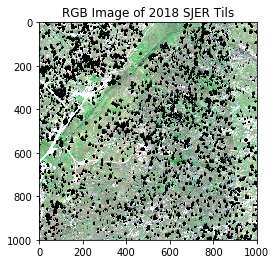

In [35]:
view = imshow(sercRefl_clean_aftermask_notree,
              bands=[58,34,19],
              stretch=0.05,
              title='RGB Image of 2018 SJER Tils'
             )

In [36]:
(m,c) = kmeans(sercRefl_clean_aftermask_notree,5,20)

Initializing clusters along diagonal of N-dimensional bounding box.
Iteration 1...  0.Iteration 1...638868 pixels reassigned.
Iteration 2...  0.Iteration 2...99414 pixels reassigned.
Iteration 3...  0.Iteration 3...26431 pixels reassigned.
Iteration 4...  0.Iteration 4...18118 pixels reassigned.
Iteration 5...  0.Iteration 5...24415 pixels reassigned.
Iteration 6...  0.Iteration 6...27399 pixels reassigned.
Iteration 7...  0.Iteration 7...26910 pixels reassigned.
Iteration 8...  0.Iteration 8...25540 pixels reassigned.
Iteration 9...  0.Iteration 9...24911 pixels reassigned.
Iteration 10...  0.0Iteration 10...27913 pixels reassigned.
Iteration 11...  0.0Iteration 11...34263 pixels reassigned.
Iteration 12...  0.0Iteration 12...39722 pixels reassigned.
Iteration 13...  0.0Iteration 13...42209 pixels reassigned.
Iteration 14...  0.0Iteration 14...42359 pixels reassigned.
Iteration 15...  0.0Iteration 15...41666 pixels reassigned.
Iteration 16...  0.0Iteration 16...42460 pixels reassigned

Text(0,0.5,'Reflectance')

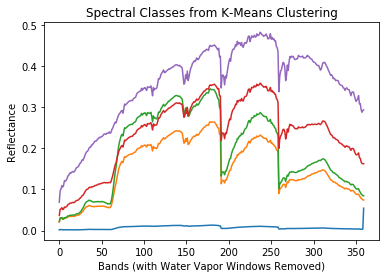

In [37]:
%matplotlib inline
import pylab
pylab.figure()
pylab.hold(1)
for i in range(c.shape[0]):
    pylab.plot(c[i])
pylab.show
pylab.title('Spectral Classes from K-Means Clustering')
pylab.xlabel('Bands (with Water Vapor Windows Removed)')
pylab.ylabel('Reflectance')

<bound method ImageView.show_data of ImageView object:
  Display bands       :  (58, 34, 19)
  Interpolation       :  <default>
  RGB data limits     :
    R: [129.0, 1820.0]
    G: [175.0, 1553.0]
    B: [106.0, 1193.0]
>

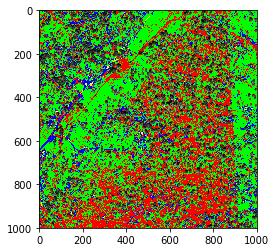

In [38]:
#%matplotlib notebook
# subplot in matplot can make side-by-sde plot
view = imshow(sercRefl, bands=(58,34,19),stretch=0.01, classes=m)
view.set_display_mode('overlay')
view.class_alpha = 1 #set transparency
view.show_data

In [39]:
# save classification results
array2raster('../output/fig/SJER_2017_unpupervised_classification_5groups_notreeonly.tif',
             (sercRefl_md['spatial extent'][0],sercRefl_md['spatial extent'][3]),
             1,-1,
             np.array(m,dtype=float),
             32611)